In [15]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import hvplot.pandas  # Asegúrate de que hvplot esté instalado

In [2]:
# Leer el archivo CSV
csv = '2025_02.csv'
df = pd.read_csv(csv)

In [3]:
df.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,M,43.0,5941349,255,31/01/2025,23:50:25,538,01/02/2025,00:00:09
1,M,29.0,8199374,021,31/01/2025,23:43:07,190,01/02/2025,00:00:13
2,M,22.0,7219819,552,31/01/2025,23:56:41,555,01/02/2025,00:00:15
3,F,46.0,5597208,128,31/01/2025,23:56:01,137,01/02/2025,00:00:23
4,M,23.0,5643887,384,31/01/2025,23:52:47,331,01/02/2025,00:00:24


In [4]:
# Limpiar el encoding de columnas (si es necesario)
def limpiar_columnas(df):
    df.columns = df.columns.str.strip()  # Eliminar espacios en blanco de los nombres de columna
    return df

# Aplicar la función de limpieza de columnas
df = limpiar_columnas(df)

In [5]:
# Convertir las fechas y horas a tipos de datos datetime
df['Fecha_Retiro'] = pd.to_datetime(df['Fecha_Retiro'], format='%d/%m/%Y')
df['Hora_Retiro'] = pd.to_datetime(df['Hora_Retiro'], format='%H:%M:%S')
df['Fecha_Arribo'] = pd.to_datetime(df['Fecha_Arribo'], format='%d/%m/%Y')
df['Hora_Arribo'] = pd.to_datetime(df['Hora_Arribo'], format='%H:%M:%S')

In [6]:
# Función para limpiar la columna de estaciones
def limpiar_estacion(estacion):
    # Si hay un guion, tomamos el primer número
    if '-' in str(estacion):
        return int(estacion.split('-')[0])  # Tomamos el primer número como entero
    else:
        return int(estacion)  # Convertir el valor a entero

# Aplicar la función de limpieza a las columnas de estaciones
df['Ciclo_Estacion_Retiro'] = df['Ciclo_Estacion_Retiro'].apply(limpiar_estacion)
df['Ciclo_EstacionArribo'] = df['Ciclo_EstacionArribo'].apply(limpiar_estacion)

In [7]:
# Calculando la duración en minutos entre la Hora de Retiro y la Hora de Arribo
df['Duracion_Minutos'] = ((df['Hora_Arribo'] - df['Hora_Retiro']).dt.total_seconds()) / 60 

In [8]:
# Añadir características relevantes
df['Hora_Retiro'] = df['Hora_Retiro'].dt.hour
df['Hora_Arribo'] = df['Hora_Arribo'].dt.hour
df['Dia_Semana_Retiro'] = df['Fecha_Retiro'].dt.day_name()

In [9]:
# Seleccionar características para la segmentación
X = df[['Edad_Usuario', 'Hora_Retiro', 'Hora_Arribo', 'Duracion_Minutos']]

In [11]:
# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [10]:
# Eliminar filas con valores NaN y obtener los índices originales
X_clean = X.dropna()
original_indices = X_clean.index

In [16]:
# Determinar el número óptimo de clusters usando el método del "Elbow"
sse = []  # Lista para almacenar la suma de errores cuadráticos
cluster_range = range(1, 11)  # Probar entre 1 y 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Almacenar la suma de errores cuadráticos

# Crear un DataFrame para la gráfica de elbow
elbow_df = pd.DataFrame({'Number of Clusters': cluster_range, 'SSE': sse})

# Graficar utilizando hvplot
elbow_plot = elbow_df.hvplot.line(x='Number of Clusters', y='SSE', title='Elbow Method for Optimal k',
                                   xlabel='Number of Clusters', ylabel='SSE', line_width=2)

# Mostrar la gráfica de elbow
elbow_plot

:Curve   [Number of Clusters]   (SSE)

In [12]:
# Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Asignar los clusters a las filas originales usando los índices
df['Cluster'] = np.nan  # Crear una nueva columna llena de NaN
df.loc[original_indices, 'Cluster'] = kmeans.labels_  # Asignar etiquetas a las filas correspondientes

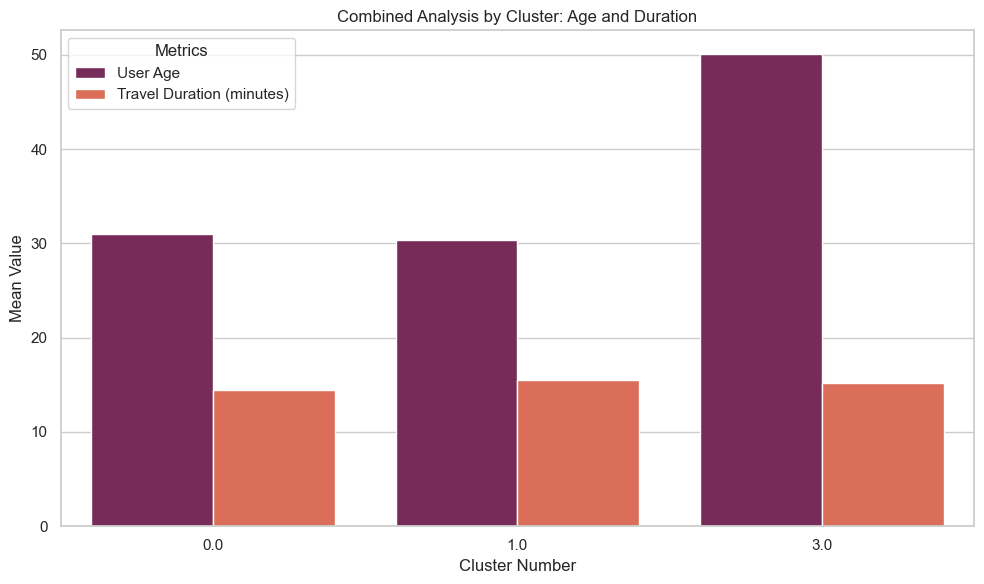

In [19]:
# Crear un DataFrame con la información requerida para graficar
cluster_summary = df.groupby('Cluster').agg({'Edad_Usuario': 'mean', 'Duracion_Minutos': 'mean'}).reset_index()

# Eliminar outliers en 'Duracion_Minutos', por ejemplo, valores negativos
cluster_summary = cluster_summary[cluster_summary['Duracion_Minutos'] > 0]

# Transformar el DataFrame con melt para intercalar las métricas
cluster_summary_long = cluster_summary.melt(id_vars='Cluster', value_vars=['Edad_Usuario', 'Duracion_Minutos'],
                                            var_name='Metric', value_name='Value')

# Renombrar las métricas
cluster_summary_long['Metric'] = cluster_summary_long['Metric'].replace({
    'Edad_Usuario': 'User Age', 
    'Duracion_Minutos': 'Travel Duration (minutes)'
})

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Crear un gráfico de barras para Edad y Duración
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Value', hue='Metric', data=cluster_summary_long, palette='rocket')

# Añadir título y etiquetas en inglés
plt.title('Combined Analysis by Cluster: Age and Duration')
plt.xlabel('Cluster Number')
plt.ylabel('Mean Value')
plt.legend(title='Metrics')
plt.xticks(rotation=0)

# Guardar el gráfico como un archivo PNG
plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import silhouette_score
import random

# Crear una muestra del conjunto de datos para calcular el Silhouette Score
sample_size = 1000  # Puedes ajustar este número según la disponibilidad de datos
if len(X_scaled) > sample_size:
    indices = random.sample(range(len(X_scaled)), sample_size)
    X_sample = X_scaled[indices]
else:
    X_sample = X_scaled  # Si hay menos datos que el tamaño de muestra, usar todos

# Aplicar K-Means a la muestra
kmeans_sample = KMeans(n_clusters=3, random_state=42)
kmeans_sample.fit(X_sample)

# Calcular el Silhouette Score de la muestra
silhouette_avg = silhouette_score(X_sample, kmeans_sample.labels_)
print(f'Silhouette Score for the sample: {silhouette_avg}')

Silhouette Score for the sample: 0.4348976101543211
